# Exploratory data analysis of mPFC & OFC lesion data

## Imports

In [2]:
import numpy as np
import polars as pl 
import pandas as pd 
import bambi as bmb
import arviz as az 
import pymc as pm
import platform
from scipy.ndimage import gaussian_filter1d
import plotly.express as px 
from IPython.display import display
import ipywidgets
from matching_pennies.io.metrics_store import load_metrics
from matching_pennies.analysis.bambi_plots import plot_trace
from matching_pennies.utils import preprocessing, plotting 

## Load Data from config

In [3]:
EXPERIMENT = "lesion_study" 
PARADIGM = "normal_mp" 

system_os = platform.system().lower()

if system_os == "windows": 
    data_path = "C:/Users/benli/Documents/code/matching-pennies/data"
    cores=4
elif system_os == "darwin":
    data_path = "/Users/ben/Documents/source/matching-pennies/data"
    cores=1

tdf, sdf, manifest = load_metrics(EXPERIMENT, PARADIGM, root=data_path)

## Analyze first session

### Prepare data

Truncate `tdf` to 1 session

In [4]:
tdf_ses1 = tdf.filter(
    pl.col("session_idx") == 1
)

Make sure there is only 1 session in `tdf_ses1`

In [5]:
tdf_ses1["session_idx"].max()

1

Get total trials completed in each session

In [6]:
max_trials = (
    tdf_ses1
    .group_by(["animal_id", "session_idx"])
    .agg(pl.col("trial_idx").max().alias("max_trial"))
)
max_trials

animal_id,session_idx,max_trial
cat,i32,u32
"""P4680""",1,160
"""P4637""",1,339
"""P4666""",1,241
"""P4640""",1,218
"""P4676""",1,218
…,…,…
"""P4643""",1,234
"""P4657""",1,262
"""P4661""",1,348


Find the minimum session length 

In [7]:
min_trial = max_trials["max_trial"].min()
min_trial

160

Truncate the dataframe to the minimum session length 

In [8]:
tdf_trunc = tdf_ses1.filter(pl.col("trial_idx") <= min_trial) 

Get the mean EFS per treatment per trial 

In [9]:
efs_by_trt_trial = (
    tdf_trunc
    .select("treatment", "trial_idx", "EFS_before_flg")
    .group_by(["treatment", "trial_idx"])
    .agg([
        pl.mean("EFS_before_flg").alias("efs_mean"),
        pl.len().alias("n"),
        pl.col("EFS_before_flg").cast(pl.Int8).sum().alias("n_efs") 
    ])
    .sort(["treatment", "trial_idx"])
)
efs_by_trt_trial

treatment,trial_idx,efs_mean,n,n_efs
cat,u32,f64,u32,i64
"""mpfc""",1,null,10,0
"""mpfc""",2,null,10,0
"""mpfc""",3,0.5,10,5
"""mpfc""",4,0.2,10,2
"""mpfc""",5,0.4,10,4
…,…,…,…,…
"""sham""",156,0.0,8,0
"""sham""",157,0.25,8,2
"""sham""",158,0.125,8,1


### Plot EFS for session 1

In [10]:
cat = {"treatment": ["sham", "mpfc", "ofc"]}

**Raw Plot**

In [11]:
fig = px.line(efs_by_trt_trial, x="trial_idx", y="efs_mean", color="treatment", category_orders=cat)
fig

**Smoothed with Gaussian Kernel**

In [12]:
SIGMA = 6
efs_smoothed = (
    efs_by_trt_trial
    .group_by("treatment")
    .map_groups(
        lambda df: df.sort("trial_idx").with_columns(
            pl.Series(
                "efs_smooth",
                gaussian_filter1d(df["efs_mean"].fill_null(0).to_numpy(), sigma=SIGMA)
            )
        )
    )
)
efs_smoothed

treatment,trial_idx,efs_mean,n,n_efs,efs_smooth
cat,u32,f64,u32,i64,f64
"""sham""",1,null,8,0,0.221571
"""sham""",2,null,8,0,0.221281
"""sham""",3,0.625,8,5,0.220704
"""sham""",4,0.25,8,2,0.219843
"""sham""",5,0.375,8,3,0.218716
…,…,…,…,…,…
"""mpfc""",156,0.3,10,3,0.227114
"""mpfc""",157,0.2,10,2,0.2324
"""mpfc""",158,0.1,10,1,0.23641


In [13]:
px.line(efs_smoothed, x="trial_idx", y="efs_smooth", color="treatment", category_orders=cat)

In [14]:
import polars as pl
import numpy as np
from scipy.ndimage import gaussian_filter1d
import plotly.express as px

# 1) precompute multiple smoothings
sigma_values = np.linspace(1, 10, dtype=np.int64)

def smooth_sigma(df: pl.DataFrame, sigma: int) -> pl.DataFrame:
    if sigma == 0:
        return df.with_columns(
            pl.col("efs_mean").alias("efs_smooth"),
            pl.lit(sigma).alias("sigma"),
        )
    return (
        df.group_by("treatment")
          .map_groups(lambda g: g.sort("trial_idx").with_columns(
              pl.Series(
                  "efs_smooth",
                  gaussian_filter1d(g["efs_mean"].fill_null(0).to_numpy(), sigma=sigma)
              )
          ))
          .with_columns(pl.lit(sigma).alias("sigma"))
    )

smoothed = pl.concat([smooth_sigma(efs_by_trt_trial, s) for s in sigma_values])

# 2) Plot with animation_frame = "sigma" (gives a slider)
order = ["sham", "ofc", "mpfc"]  # your desired legend/color order
pdf = smoothed.to_pandas()

fig = px.line(
    pdf,
    x="trial_idx",
    y="efs_smooth",
    color="treatment",
    animation_frame="sigma",
    category_orders={"treatment": order, "sigma": sigma_values},
    color_discrete_map={"sham": "#1f77b4", "ofc": "#ff7f0e", "mpfc": "#2ca02c"},  # optional but keeps colors stable
    title="Mean EFS per Trial by Treatment — Gaussian smoothing σ"
)

# keep y-range stable across frames (optional, but nicer)
ymin = 0
ymax = max(0.6, float(pdf["efs_smooth"].max(skipna=True)))
fig.update_yaxes(range=[ymin, ymax])
fig.update_layout(legend_traceorder="normal", width=800, height=600)
fig


**Plot cumulative EFS mean**

In [15]:
efs_by_trt_trial = efs_by_trt_trial.with_columns(
    pl.col("efs_mean")
    .fill_null(0)
    .cum_sum()
    .over("treatment")
    .alias("efs_cumsum")
)

In [16]:
px.line(
    efs_by_trt_trial,
    x="trial_idx", 
    y="efs_cumsum", 
    color="treatment",
    category_orders=cat,
    title="Cumulative sum of EFS over post-lesion session 1"
)

## EFS cumulative sum in first 3 sessions

Truncate the data to the 3 sessions

In [17]:
tdf_trunc = tdf.filter(pl.col("session_idx") <= 3)

Truncate the data to the lowest number of trials

In [18]:
max_trials = (
    tdf_trunc
    .group_by(["animal_id", "session_idx"])
    .agg(pl.col("trial_idx").max().alias("num_trials"))
)
min_ses = max_trials["num_trials"].min()
min_ses
tdf_trunc = tdf_trunc.filter(pl.col("trial_idx") <= min_ses)
tdf_trunc["trial_idx"].max()

152

Make the average EFS column

In [19]:
tdf_efs = (
    tdf_trunc
    .select("treatment", "session_idx", "trial_idx", "EFS_before_flg")
    .group_by(["treatment", "session_idx", "trial_idx"])
    .agg([
        pl.mean("EFS_before_flg").alias("efs_mean"),
        pl.len().alias("n"),
        pl.col("EFS_before_flg").cast(pl.Int8).sum().alias("n_efs") 
    ])
)

Make the cumulative sum of mean EFS column

In [20]:
tdf_efs = (
    tdf_efs
    .sort(["treatment", "session_idx", "trial_idx"])
    .with_columns(
        pl.col("efs_mean")
        .fill_null(0)
        .cum_sum()
        .over(["treatment", "session_idx"])
        .alias("efs_cumsum")
    )
)
tdf_efs

treatment,session_idx,trial_idx,efs_mean,n,n_efs,efs_cumsum
cat,i32,u32,f64,u32,i64,f64
"""mpfc""",1,1,null,10,0,0.0
"""mpfc""",1,2,null,10,0,0.0
"""mpfc""",1,3,0.5,10,5,0.5
"""mpfc""",1,4,0.2,10,2,0.7
"""mpfc""",1,5,0.4,10,4,1.1
…,…,…,…,…,…,…
"""sham""",3,148,0.125,8,1,22.25
"""sham""",3,149,0.25,8,2,22.5
"""sham""",3,150,0.125,8,1,22.625


Create a category map for plotting

In [21]:
cat_orders = {
    "treatment": cat["treatment"], # Re-using map from above for consistency
    "session_idx": [1, 2, 3]
}

Plot cumulative sum of mean EFS for each session

In [22]:
fig = px.line(
    tdf_efs,
    x="trial_idx",
    y="efs_cumsum",
    color="treatment",
    facet_row="session_idx",
    category_orders=cat_orders
)

fig.update_layout(height=900, title="Cumulative EFS by Treatment across Sessions")
fig.update_layout(legend_title_text="Treatment")
fig.update_xaxes(title_text="Trial Index")
fig.update_yaxes(title_text="EFS CumSum")

fig.show()

## AUC stats

From the previous sections we see visually that OFC lesioned animals seem to have higher levels of EFS in the first session. Lets analyze this and see if there are any significant differences from shams.

Since trial intervals are evenly spaced: 
$$AUC_{EFS} = \sum_{i=1}^{T} EFS \ Mean(i) \Delta t = CumSum(EFS)_{max}$$

In [23]:
ses1_auc = (
    tdf_trunc.filter(pl.col("session_idx") == 1)
    .group_by(["animal_id", "treatment", "trial_idx"])
    .agg(pl.mean("EFS_before_flg").alias("efs_mean"))
    .group_by(["animal_id", "treatment"])
    .agg(pl.col("efs_mean").sum().alias("AUC"))   # AUC == final cumsum here
)
ses1_auc

animal_id,treatment,AUC
cat,cat,f64
"""P4680""","""ofc""",56.0
"""P4659""","""mpfc""",31.0
"""P4668""","""sham""",50.0
"""P4661""","""sham""",20.0
"""P4666""","""mpfc""",20.0
…,…,…
"""P4638""","""sham""",30.0
"""P4676""","""sham""",17.0
"""P4640""","""mpfc""",34.0


Plot Histogram for each treatment group

In [24]:
fig = px.violin(
    ses1_auc,
    x="treatment",
    y="AUC",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Session 1 Post-Lesion Mean AUC(EFS)"
)
fig.show()


This raises more questions than it answers. Bimodal OFC is interesting, is this from the lesion increasing EFS? Or do these rats just love to EFS? We need to bring in the pre-lesion baseline to answer this. 

## EFS GLMM Analysis 

Basic data prep 

In [25]:
tdf_scaled = tdf.clone()
tdf_scaled = preprocessing.scale_col(tdf_scaled, "trial_idx")
tdf_scaled = preprocessing.scale_col(tdf_scaled, "session_idx") 
keep_cols = ["animal_id", "treatment", "trial_idx_scaled", "session_idx_scaled", "EFS_before_flg"]
efs_df = tdf_scaled[keep_cols] 
efs_df = efs_df.filter(pl.col("EFS_before_flg").is_not_null())
efs_df = efs_df.to_pandas()
efs_df["treatment"] = pd.Categorical(efs_df["treatment"], categories=["sham", "mpfc", "ofc"], ordered=True)

efs_df

,animal_id,treatment,trial_idx_scaled,session_idx_scaled,EFS_before_flg
0,P4637,sham,0.004808,0.000000,1
1,P4637,sham,0.007212,0.000000,0
2,P4637,sham,0.009615,0.000000,0
3,P4637,sham,0.012019,0.000000,0
4,P4637,sham,0.014423,0.000000,0
...,...,...,...,...,...
18300,P4680,ofc,0.596154,0.666667,0
18301,P4680,ofc,0.598558,0.666667,1
18302,P4680,ofc,0.600962,0.666667,1
18303,P4680,ofc,0.603365,0.666667,0


Define model and fit

In [26]:
efs_formula = "EFS_before_flg ~ treatment*trial_idx_scaled + treatment*session_idx_scaled + (1 | animal_id)"
efs_model = bmb.Model(
    efs_formula, 
    efs_df, 
    family="bernoulli"
)
idata_efs = efs_model.fit(cores=cores, chains=4, idata_kwargs={"log_likelihood": True})

Modeling the probability that EFS_before_flg==1
Initializing NUTS using jitter+adapt_diag...
c:\Users\benli\Documents\code\matching-pennies\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning:

PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, treatment, trial_idx_scaled, treatment:trial_idx_scaled, session_idx_scaled, treatment:session_idx_scaled, 1|animal_id_sigma, 1|animal_id_

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Summarize results of GLMM 

In [27]:
az.summary(idata_efs) 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.254,0.180,-1.587,-0.916,0.005,0.003,1156.0,1709.0,1.00
treatment[mpfc],0.049,0.246,-0.442,0.474,0.007,0.005,1172.0,1747.0,1.00
treatment[ofc],0.358,0.278,-0.156,0.877,0.009,0.005,1008.0,1983.0,1.00
trial_idx_scaled,-0.944,0.181,-1.283,-0.603,0.004,0.003,2208.0,2304.0,1.00
treatment:trial_idx_scaled[mpfc],-0.517,0.254,-0.990,-0.030,0.005,0.004,2522.0,2593.0,1.00
treatment:trial_idx_scaled[ofc],-0.546,0.295,-1.110,-0.005,0.006,0.005,2569.0,2777.0,1.00
session_idx_scaled,-0.398,0.123,-0.628,-0.170,0.003,0.002,2115.0,2423.0,1.00
treatment:session_idx_scaled[mpfc],-0.062,0.174,-0.393,0.260,0.004,0.002,2355.0,2893.0,1.00
treatment:session_idx_scaled[ofc],-0.168,0.185,-0.539,0.158,0.004,0.003,2414.0,2606.0,1.00
1|animal_id_sigma,0.474,0.085,0.326,0.632,0.003,0.002,771.0,1437.0,1.01


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'treatment'}>,
        <Axes: title={'center': 'treatment'}>],
       [<Axes: title={'center': 'trial_idx_scaled'}>,
        <Axes: title={'center': 'trial_idx_scaled'}>],
       [<Axes: title={'center': 'treatment:trial_idx_scaled'}>,
        <Axes: title={'center': 'treatment:trial_idx_scaled'}>],
       [<Axes: title={'center': 'session_idx_scaled'}>,
        <Axes: title={'center': 'session_idx_scaled'}>],
       [<Axes: title={'center': 'treatment:session_idx_scaled'}>,
        <Axes: title={'center': 'treatment:session_idx_scaled'}>]],
      dtype=object)

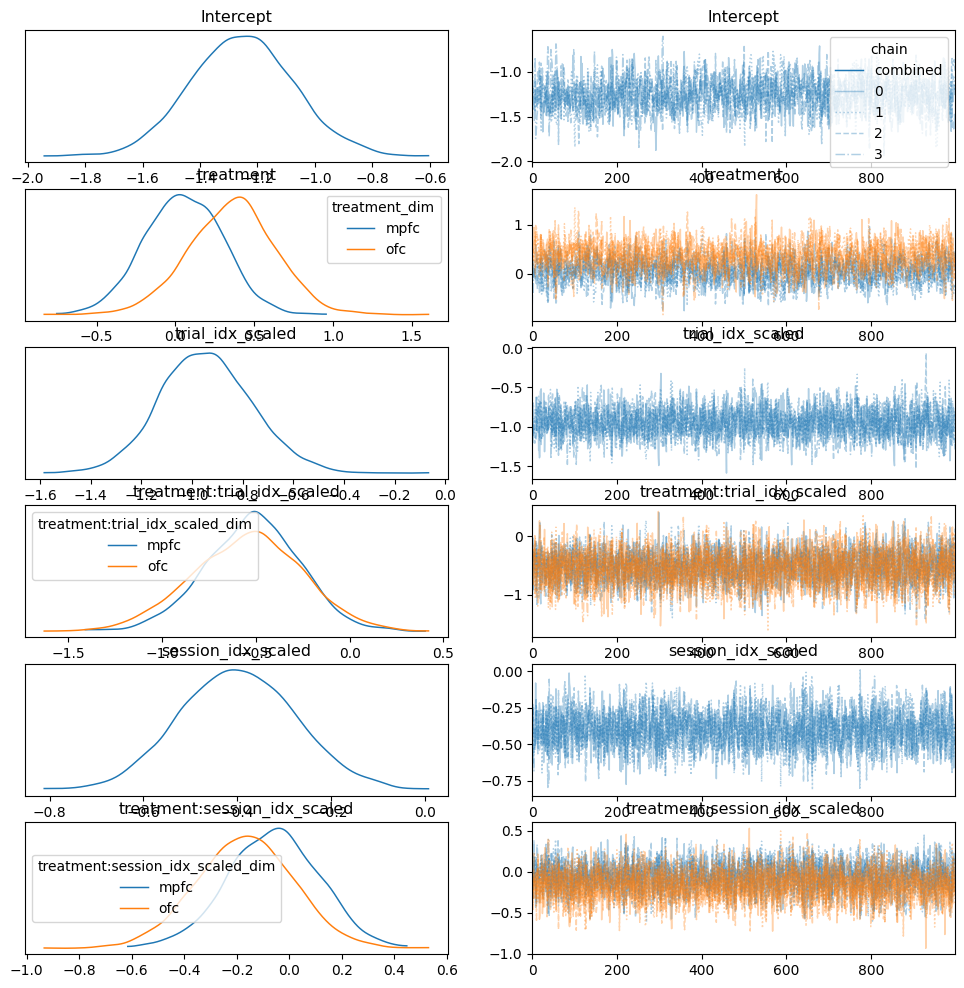

In [28]:
plt_vars = ["Intercept", "treatment", "trial_idx_scaled", "treatment:trial_idx_scaled", "session_idx_scaled", "treatment:session_idx_scaled"]
az.plot_trace(idata_efs, var_names=plt_vars, combined=True, legend=True)

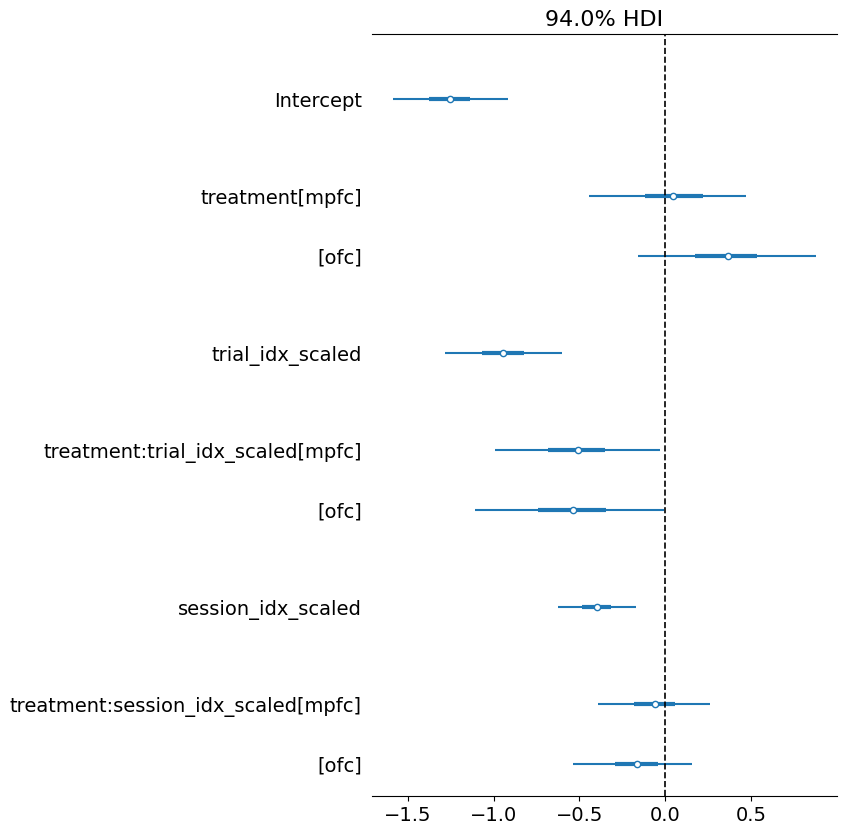

In [29]:
import matplotlib.pyplot as plt 
ax = az.plot_forest(idata_efs, combined=True, var_names=plt_vars, show=False)

ax = ax[0]

# Add a vertical dotted line at x=0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1.2)

plt.show()

<Axes: xlabel='EFS_before_flg'>

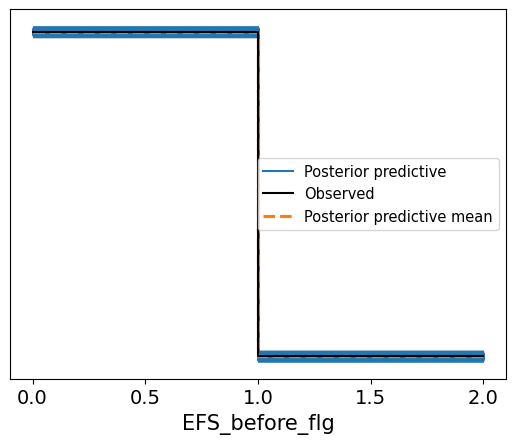

In [30]:
ppc = efs_model.predict(idata_efs, kind="response", inplace=False)
az.plot_ppc(ppc)

## Other Behaviours

Make clone of DataFrames 

In [31]:
df = tdf.clone()
# Truncate trials to minimum done in one session - all animals represented 
df = preprocessing.clip_to_minimum_extent(df, "trial_idx")

### WSLS

Plot Win-Stay and Lose-Switch for each treatment. Averaged over animals and sessions

**Win-Stay**

In [32]:
df = preprocessing.bin_data(df, 20)
ws_bin = plotting.bin_and_aggregate_flag(df, "WinStay_NoMultWellResp_flg")
plotting.line_by_treatment_across_bins(
    ws_bin,
    y="WinStay_NoMultWellResp_flg_fraction",
    category_orders=cat
)

**Lose-Switch**

In [33]:
df = preprocessing.bin_data(df, 20)
ls_bin = plotting.bin_and_aggregate_flag(df, "LoseSwitch_NoMultWellResp_flg")
plotting.line_by_treatment_across_bins(
    ls_bin,
    y="LoseSwitch_NoMultWellResp_flg_fraction",
    category_orders=cat
)

### Licking 

#### Licks Before Reward

In [34]:
lbr_bin = plotting.bin_and_aggregate_flag(df, "LicksBeforeRew")
plotting.line_by_treatment_across_bins(
    lbr_bin,
    y="LicksBeforeRew_fraction",
    category_orders=cat
)

#### Licks Total

In [35]:
lt_bin = plotting.bin_and_aggregate_flag(df, "LicksTotal")
plotting.line_by_treatment_across_bins(
    lt_bin,
    y="LicksTotal_fraction", 
    category_orders=cat
)

It looks like OFC rats might be licking more than the other groups. Lets run a GLMM on the raw data to see. 

Lets take a look at the lick histogram to see if there are any outliers 

In [36]:
px.histogram(
    df,
    x="LicksTotal", 
    color="treatment", 
    category_orders=cat
)

In [37]:
df_filt = df.filter(pl.col("LicksTotal") <= 100) 
px.histogram(
    df_filt, 
    x="LicksTotal", 
    color="treatment", 
    category_orders=cat
)

##### Licks Total GLMM

In [38]:
formula = "LicksTotal ~ trial_idx_scaled * treatment + (1|animal_id)"
tdf_pan = tdf[["animal_id", "treatment", "trial_idx", "LicksTotal"]]
tdf_pan = tdf_pan.filter(pl.col("LicksTotal") <= 100)
tdf_pan = preprocessing.scale_col(tdf_pan, "trial_idx")
tdf_pan = tdf_pan.filter(pl.col("LicksTotal").is_not_null()).to_pandas()
tdf_pan["treatment"] = pd.Categorical(tdf_pan["treatment"], categories=["sham", "mpfc", "ofc"], ordered=True)
model_lick = bmb.Model(
    formula,
    tdf_pan,
    family="negativebinomial"
)

idata_lick = model_lick.fit(cores=cores, chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, trial_idx_scaled, treatment, trial_idx_scaled:treatment, 1|animal_id_sigma, 1|animal_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.


In [39]:
az.summary(idata_lick)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.965,0.011,0.944,0.986,0.000,0.000,2934.0,2521.0,1.0
Intercept,2.915,0.085,2.762,3.077,0.002,0.002,1243.0,1708.0,1.0
trial_idx_scaled,-0.483,0.073,-0.624,-0.347,0.002,0.001,2294.0,2656.0,1.0
treatment[mpfc],-0.197,0.115,-0.425,0.007,0.003,0.002,1125.0,1836.0,1.0
treatment[ofc],0.135,0.132,-0.092,0.417,0.004,0.003,1196.0,1446.0,1.0
trial_idx_scaled:treatment[mpfc],0.272,0.100,0.092,0.462,0.002,0.001,2325.0,2871.0,1.0
trial_idx_scaled:treatment[ofc],-0.207,0.124,-0.442,0.024,0.002,0.002,2538.0,2834.0,1.0
1|animal_id_sigma,0.221,0.039,0.155,0.293,0.001,0.001,821.0,1577.0,1.0
1|animal_id[P4637],-0.100,0.089,-0.264,0.067,0.002,0.002,1314.0,1882.0,1.0
1|animal_id[P4638],-0.018,0.090,-0.190,0.154,0.002,0.002,1418.0,1837.0,1.0


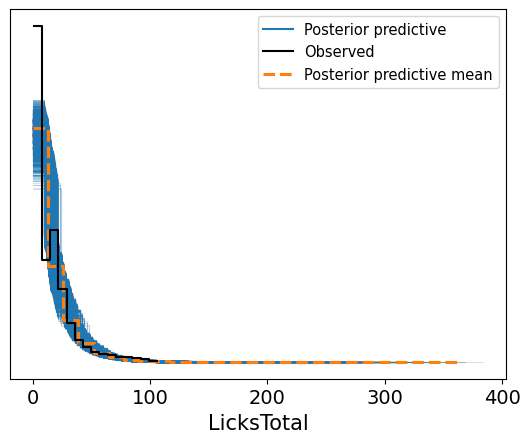

<Axes: xlabel='LicksTotal'>

In [40]:
ppc = model_lick.predict(
    idata_lick,
    kind="response",
    inplace=False
)
az.plot_ppc(ppc, show=True)

Ok, it looks like the model is fitting pretty well. Lets take a look at the posteriors

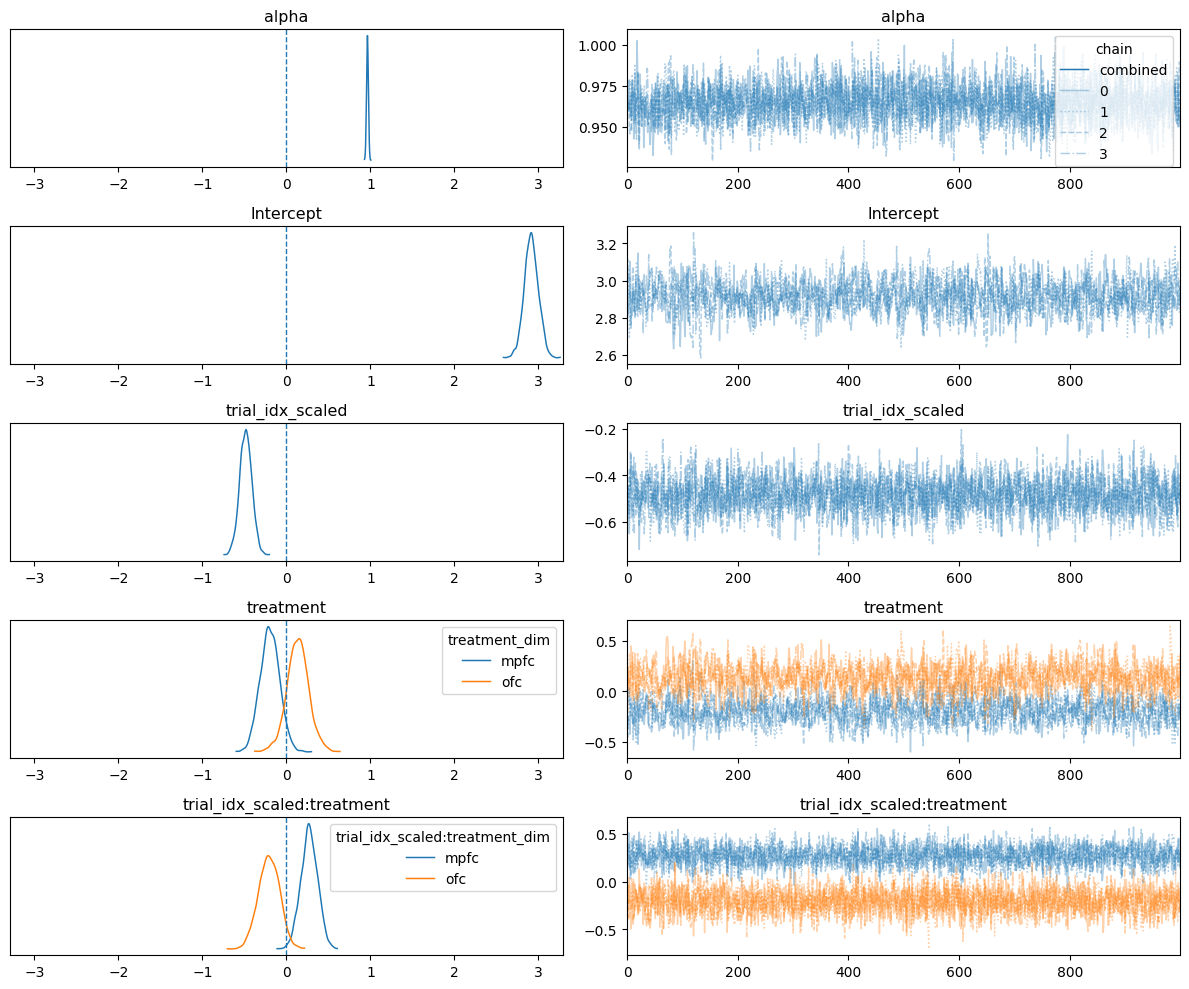

In [41]:
plot_vars = ["alpha", "Intercept", "trial_idx_scaled", "treatment", "trial_idx_scaled:treatment"]
fig, ax = plot_trace(idata_lick, var_names=plot_vars, compact=True)

### Inter-Trial Interval

In [42]:
df = tdf.clone()

In [43]:
from matching_pennies.utils.search_cols import search_cols
search_cols("inter", df)

['InterTrialInterval']

In [44]:
px.histogram(
    df, 
    x="InterTrialInterval", 
    color="treatment", 
    category_orders=cat
)

# Baseline vs. lesion comparison

## Load baseline data

In [45]:
EXPERIMENT = "lesion_study" 
PARADIGM = "baseline" 

tdf_bl, sdf_bl, manifest_bl = load_metrics(EXPERIMENT, PARADIGM, root=data_path) 

Take the AUC(EFS) for each animal in each baseline session. Compare this to the animals AUC(EFS) in session 1 post-surgery 

In [46]:
bl_trunc = tdf_bl.filter(pl.col("trial_idx") <= 150) 

In [47]:
bl_auc = (
    bl_trunc
    .group_by(["animal_id", "treatment", "session_idx", "trial_idx"])
    .agg(pl.mean("EFS_before_flg").alias("efs_mean"))
    .group_by(["animal_id", "treatment", "session_idx"])
    .agg(pl.col("efs_mean").sum().alias("AUC"))   # AUC == final cumsum here
    .group_by(["animal_id", "treatment"])
    .agg(pl.mean("AUC").alias("mean_auc"))
)
bl_auc.sort(["treatment", "animal_id"])

animal_id,treatment,mean_auc
cat,cat,f64
"""P4640""","""mpfc""",34.666667
"""P4647""","""mpfc""",20.333333
"""P4648""","""mpfc""",26.0
"""P4651""","""mpfc""",38.333333
"""P4657""","""mpfc""",42.333333
…,…,…
"""P4662""","""sham""",45.0
"""P4667""","""sham""",34.0
"""P4668""","""sham""",34.333333


In [48]:
# Merge baseline and post-lesion data
prepost = (
    ses1_auc.join(
        bl_auc,
        on=["animal_id", "treatment"],
        how="inner"
    )
    .with_columns(
        (pl.col("AUC") - pl.col("mean_auc")).alias("delta_auc")
    )
)

prepost = prepost.sort("treatment")
prepost

animal_id,treatment,AUC,mean_auc,delta_auc
cat,cat,f64,f64,f64
"""P4659""","""mpfc""",31.0,34.333333,-3.333333
"""P4669""","""mpfc""",40.0,27.666667,12.333333
"""P4657""","""mpfc""",24.0,42.333333,-18.333333
"""P4648""","""mpfc""",25.0,26.0,-1.0
"""P4640""","""mpfc""",34.0,34.666667,-0.666667
…,…,…,…,…
"""P4667""","""sham""",35.0,34.0,1.0
"""P4662""","""sham""",23.0,45.0,-22.0
"""P4677""","""sham""",30.0,36.333333,-6.333333


In [49]:
(
    prepost
    .group_by("treatment")
    .agg(pl.mean("delta_auc").alias("mean_delta_auc"))
)

treatment,mean_delta_auc
cat,f64
"""sham""",-7.666667
"""ofc""",8.777778
"""mpfc""",-3.566667


Lets make a violin plot of the baseline AUC to check variance

In [50]:
fig = px.violin(
    bl_auc,
    x="treatment",
    y="mean_auc",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Pre-lesion Mean AUC over all sessions"
)
fig.show()

Now lets visualize the delta AUC. 

In [51]:
fig = px.violin(
    prepost,
    x="treatment",
    y="delta_auc",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="delta AUC(post-lesion) - mean AUC(pre-lesion)"
)
fig.show()

OFC has a high baseline variance as well. Lets compute delta AUC again, but with the max(AUC) from baseline rather than mean(AUC), to get a worst case-baseline

In [52]:
bl_auc_max = (
    bl_trunc
    .group_by(["animal_id", "treatment", "session_idx", "trial_idx"])
    .agg(pl.mean("EFS_before_flg").alias("efs_mean"))
    .group_by(["animal_id", "treatment", "session_idx"])
    .agg(pl.col("efs_mean").sum().alias("AUC"))   # AUC == final cumsum here
    .group_by(["animal_id", "treatment"])
    .agg(pl.max("AUC").alias("max_auc"))
)
bl_auc_max.sort(["treatment", "animal_id"])

animal_id,treatment,max_auc
cat,cat,f64
"""P4640""","""mpfc""",43.0
"""P4647""","""mpfc""",28.0
"""P4648""","""mpfc""",31.0
"""P4651""","""mpfc""",51.0
"""P4657""","""mpfc""",52.0
…,…,…
"""P4662""","""sham""",61.0
"""P4667""","""sham""",45.0
"""P4668""","""sham""",45.0


In [53]:
fig = px.violin(
    bl_auc_max,
    x="treatment",
    y="max_auc",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Pre-lesion MAX AUC over all sessions"
)
fig.show()

Compute delta AUC again but with max(AUC) from baseline. This answers the question of "Is EFS in the first post-lesion session higher than the highest EFS from their baseline behaviour?"

In [54]:
# Merge baseline and post-lesion data
prepost_max = (
    ses1_auc.join(
        bl_auc_max,
        on=["animal_id", "treatment"],
        how="inner"
    )
    .with_columns(
        (pl.col("AUC") - pl.col("max_auc")).alias("delta_auc")
    )
)

prepost_max = prepost_max.sort("treatment")
prepost_max

animal_id,treatment,AUC,max_auc,delta_auc
cat,cat,f64,f64,f64
"""P4640""","""mpfc""",34.0,43.0,-9.0
"""P4647""","""mpfc""",34.0,28.0,6.0
"""P4671""","""mpfc""",11.0,20.0,-9.0
"""P4657""","""mpfc""",24.0,52.0,-28.0
"""P4651""","""mpfc""",30.0,51.0,-21.0
…,…,…,…,…
"""P4667""","""sham""",35.0,45.0,-10.0
"""P4662""","""sham""",23.0,61.0,-38.0
"""P4676""","""sham""",17.0,22.0,-5.0


In [55]:
fig = px.violin(
    prepost_max,
    x="treatment",
    y="delta_auc",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Difference between post-lesion session 1 and the maximum EFS session from baseline"
)
fig.show()

MAYBE: compute Z-scored post-lesion deviations in AUC? 
will answer: Were post-lesion EFS values outside the range of normal baseline variability 

# Residual Principal Component Analysis

We want to determine which behavioural variables account for the most variance across groups, while accounting for the known affects within-session

## Step 1: Detrend behavioural variables

We will detrend the data via residualization to preserve treatment level information 

General workflow of detrending: 
1. Look at raw data, does there seem to be a trend?
    1. If no, Z-score, then good for PCA
2. Fit several candidate models, then compare 
3. Use the best-fitting model for detrending 

### EFS detrending

Plot binned data

#### Aside to figure out plotting...

In [56]:
df = preprocessing.bin_data(tdf_trunc, 20)
ls_bins = plotting.bin_and_aggregate_flag(
    df,
    "LoseSwitch_NoMultWellResp_flg",
    y_mode="fraction" 
)
ls_bins
plotting.line_by_treatment_across_bins(
    ls_bins,
    x="bin", 
    y="LoseSwitch_NoMultWellResp_flg_fraction",
    category_orders=cat
)

#### Back to EFS :) 

In [57]:
# testing new plotting code 
tdf_bin = preprocessing.bin_data(tdf_trunc, 20, bin_on="trial_idx")

efs_binagg = plotting.bin_and_aggregate_flag(
    tdf_bin,
    "EFS_before_flg",
    bin_col="bin",
    group_cols=["treatment"],   # 👈 only treatment
    y_mode="fraction",
    y_name="efs_fraction",
)

fig = plotting.line_by_treatment_across_bins(
    df=efs_binagg,
    x="bin",
    y="efs_fraction",
    color="treatment",
    category_orders=cat,
    title="EFS fraction over trial bins",
    y_label="EFS Fraction",
)
fig.show()


Ok, Now that we have a rough idea of the shape of the EFS, lets make a GLMM **WITHOUT** a treatment term to get an treatment agnostic EFS decay curve. 

In [58]:
# Scale EFS 
df = preprocessing.scale_col(tdf_trunc, "trial_idx")
df = preprocessing.scale_col(df, "session_idx")
df = df[["animal_id", "treatment", "session_idx", "session_idx_scaled", "trial_idx", "trial_idx_scaled", "EFS_before_flg"]].drop_nulls(pl.col("EFS_before_flg"))
df = df.to_pandas()

In [59]:
detrend_formula = "EFS_before_flg ~ trial_idx_scaled + session_idx_scaled + (1 | animal_id)"
detrend_model = bmb.Model(
    detrend_formula,
    df,
    family="bernoulli",
)
idata = detrend_model.fit(idata_kwargs={"log_likelihood": True}, cores=cores, chains=4)
az.summary(idata)

Modeling the probability that EFS_before_flg==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, trial_idx_scaled, session_idx_scaled, 1|animal_id_sigma, 1|animal_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.862,0.106,-1.053,-0.658,0.003,0.002,969.0,1481.0,1.0
trial_idx_scaled,-1.063,0.091,-1.234,-0.897,0.001,0.002,4538.0,2961.0,1.0
session_idx_scaled,-0.368,0.063,-0.491,-0.255,0.001,0.001,3842.0,3063.0,1.0
1|animal_id_sigma,0.440,0.073,0.313,0.582,0.003,0.002,819.0,1488.0,1.0
1|animal_id[P4637],-0.696,0.173,-1.005,-0.354,0.004,0.003,2003.0,2567.0,1.0
1|animal_id[P4638],0.385,0.145,0.105,0.652,0.004,0.002,1560.0,2285.0,1.0
1|animal_id[P4640],0.039,0.149,-0.243,0.328,0.003,0.002,1844.0,2675.0,1.0
1|animal_id[P4643],0.240,0.142,-0.041,0.488,0.004,0.002,1647.0,2339.0,1.0
1|animal_id[P4647],-0.138,0.149,-0.422,0.125,0.004,0.002,1586.0,2677.0,1.0
1|animal_id[P4648],-0.344,0.179,-0.674,-0.013,0.004,0.003,2032.0,2458.0,1.0


In [60]:
detrend_model

       Formula: EFS_before_flg ~ trial_idx_scaled + session_idx_scaled + (1 | animal_id)
        Family: bernoulli
          Link: p = logit
  Observations: 10649
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.5)
            trial_idx_scaled ~ Normal(mu: 0.0, sigma: 3.4871)
            session_idx_scaled ~ Normal(mu: 0.0, sigma: 2.4584)
        
        Group-level effects
            1|animal_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.2924))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'trial_idx_scaled'}>,
        <Axes: title={'center': 'trial_idx_scaled'}>],
       [<Axes: title={'center': 'session_idx_scaled'}>,
        <Axes: title={'center': 'session_idx_scaled'}>],
       [<Axes: title={'center': '1|animal_id_sigma'}>,
        <Axes: title={'center': '1|animal_id_sigma'}>],
       [<Axes: title={'center': '1|animal_id'}>,
        <Axes: title={'center': '1|animal_id'}>]], dtype=object)

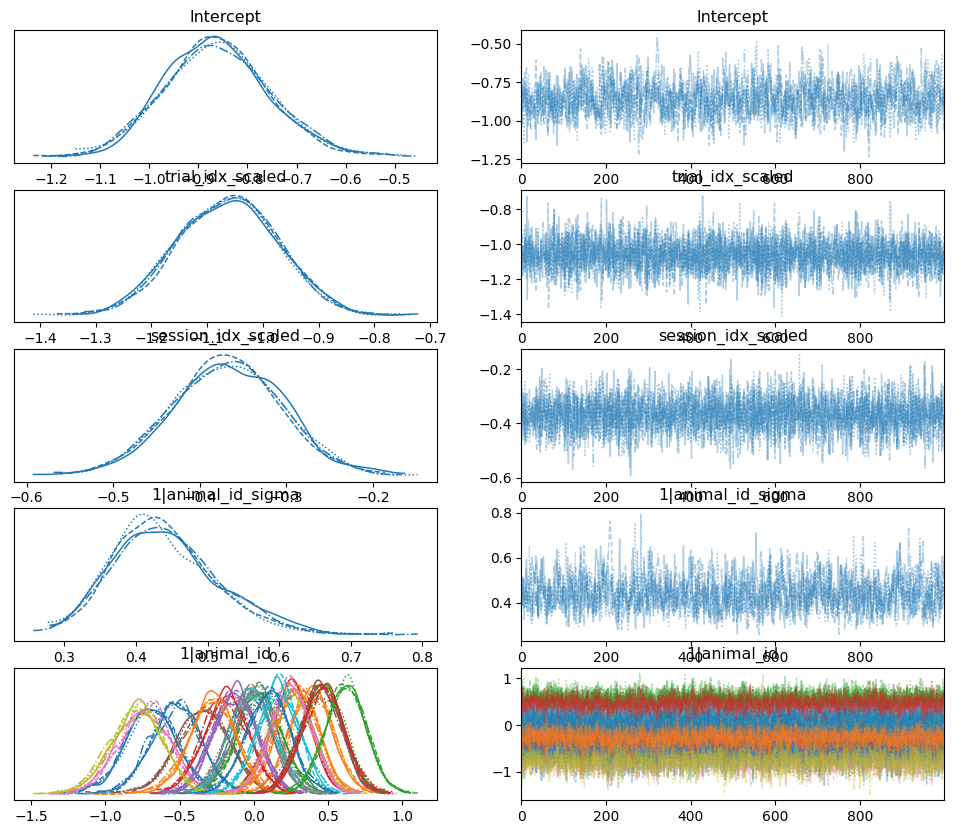

In [61]:
az.plot_trace(idata)

In [62]:
type(detrend_model)

bambi.models.Model

Detrending the data

In [63]:
df_full = df.copy()

# Reference: trial_idx_scaled = 0, session_idx_scaled = 0 for every row 
df_ref = df.copy()
df_ref["trial_idx_scaled"] = 0.0
df_ref["session_idx_scaled"] = 0.0

`df_ref` is basically saying "what if this trial happened at baseline trial and session?" 

Get the posterior means with Bambi 

In [64]:
# Full predictions (actual trial/session)
p_full_da = detrend_model.predict(
    idata=idata,
    data=df_full,
    kind="response_params",      # posterior of mean prob
    inplace=False,
)  # xarray DataArray with dims (chain, draw, obs)

# Baseline predictions (trial=session=0)
p_ref_da = detrend_model.predict(
    idata=idata,
    data=df_ref,
    kind="response_params",
    inplace=False,
)

In [65]:
p_full_mean = p_full_da.posterior.mean(dim=("chain", "draw"))["p"]
p_ref_mean = p_ref_da.posterior.mean(dim=("chain", "draw"))["p"]

Construct detrended columns 

In [66]:
df["p_full"] = p_full_mean
df["p_base"] = p_ref_mean 
df["p_trend"] = df["p_full"] - df["p_base"] 
df["p_detrended"] = df["p_base"]

In [67]:
df

,animal_id,treatment,session_idx,session_idx_scaled,trial_idx,trial_idx_scaled,EFS_before_flg,p_full,p_base,p_trend,p_detrended
0,P4637,sham,1,0.0,3,0.013245,1,0.173106,0.175128,-0.002022,0.175128
1,P4637,sham,1,0.0,4,0.019868,0,0.172102,0.175128,-0.003026,0.175128
2,P4637,sham,1,0.0,5,0.026490,0,0.171103,0.175128,-0.004026,0.175128
3,P4637,sham,1,0.0,6,0.033113,0,0.170108,0.175128,-0.005021,0.175128
4,P4637,sham,1,0.0,7,0.039735,0,0.169118,0.175128,-0.006011,0.175128
...,...,...,...,...,...,...,...,...,...,...,...
10644,P4680,ofc,3,1.0,148,0.973510,0,0.142449,0.402471,-0.260022,0.402471
10645,P4680,ofc,3,1.0,149,0.980132,0,0.141595,0.402471,-0.260877,0.402471
10646,P4680,ofc,3,1.0,150,0.986755,0,0.140745,0.402471,-0.261727,0.402471
10647,P4680,ofc,3,1.0,151,0.993377,0,0.139899,0.402471,-0.262573,0.402471


In [68]:
pdf = pl.from_pandas(df)

by_trial = (
    pdf
    .group_by(["treatment", "trial_idx"])
    .agg(
        raw_rate      = pl.col("EFS_before_flg").mean(),
        p_full_mean   = pl.col("p_full").mean(),
        p_det_mean    = pl.col("p_detrended").mean(),
    )
    .sort(["treatment", "trial_idx"])
)

In [69]:
by_trial

treatment,trial_idx,raw_rate,p_full_mean,p_det_mean
cat,u32,f64,f64,f64
"""mpfc""",3,0.448276,0.246896,0.282775
"""mpfc""",4,0.37931,0.24561,0.282775
"""mpfc""",5,0.344828,0.244329,0.282775
"""mpfc""",6,0.344828,0.243052,0.282775
"""mpfc""",7,0.37931,0.24178,0.282775
…,…,…,…,…
"""sham""",148,0.041667,0.118052,0.303718
"""sham""",149,0.166667,0.117336,0.303718
"""sham""",150,0.125,0.116624,0.303718


In [70]:
fig = px.line(
    by_trial,
    x="trial_idx",
    y=["raw_rate", "p_full_mean", "p_det_mean"],
    color="treatment",
    category_orders=cat
)
fig.update_layout(
    title="Raw EFS vs model vs detrended across trials",
    yaxis_title="Probability / Rate of EFS"
)
fig.show()

Plot without raw rate for clarity

In [71]:
fig = px.line(
    by_trial,
    x="trial_idx",
    y=["p_full_mean", "p_det_mean"],
    color="treatment",
    category_orders=cat
)
fig.update_layout(
    title="model vs detrended across EFS trials",
    yaxis_title="Probability / Rate of EFS"
)
fig.show()

In [72]:
by_session = (
    pdf
    .group_by(["treatment", "session_idx"])
    .agg(
        raw_rate   = pl.col("EFS_before_flg").mean(),
        det_prob   = pl.col("p_detrended").mean(),
    )
    .sort(["treatment", "session_idx"])
    .to_pandas()
)

fig = px.line(
    by_session,
    x="session_idx",
    y=["raw_rate", "det_prob"],
    color="treatment",
    title="Session-wise raw vs detrended EFS"
)
fig.update_yaxes(title="EFS")
fig.show()


## Other EFS models

In [76]:
tdf["error_flg"]

error_flg
i8
0
1
0
1
0
…
1
0
1
